In [1]:
!pip install torch
!pip install transformers[torch]
!pip install tqdm
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install nltk

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Check if GPU is available
if torch.cuda.is_available():
    # Print the name of the GPU
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU available, using CPU.")

Tesla T4


In [6]:
df = pd.read_excel("Aggregated.xlsx")
print(df)

                                             Sequence  Label
0     ADDKCEDSLRREIACTKCRDRVRTDDYFYECCTSESTFKKCQTMLHQ      0
1                       MDIITLGWVGVLSVFTLSIAFVVWGRHGM      0
2                     IVGGVEAVPGVWPYQAALFIIDMYFCGGSLI      0
3      AVKCIGWQETCNGKLPCCDGCVMCECNIMGQNCRCNHPKATSECES      0
4                    MSDINATRLPIWGIGCDPCIGDDVTILLTRGE      0
...                                               ...    ...
8341                    ALLDKLKSLGKVVGKVALGVVQNYLNPRQ      1
8342                KKCGFFCKLKNKLKSTGSRSNIAAGTHGGTFRV      1
8343                      DIGTKILGGVKTALKGALKELASTYVN      1
8344                     KSGGGGWGSGGGGGGGGGWWWSGWGVDR      1
8345                             AMRTTYNRPCLFASKRTKEM      1

[8346 rows x 2 columns]


In [7]:
from sklearn.model_selection import train_test_split
from transformers import BertModel, TrainingArguments, AutoTokenizer, TrainingArguments, AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn as nn
import torch.nn.init as init

class ProteinSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets, tokenizer, max_length):
        self.sequences = sequences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = str(self.sequences[idx])
        target = self.targets[idx]
        encoding = self.tokenizer.encode_plus(
            sequence,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.long)
        }

PRE_TRAINED_MODEL_NAME = 'Rostlab/prot_bert_bfd_localization'

class ProteinClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ProteinClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.classifier = nn.Sequential(nn.Dropout(p=0.4),
                                        nn.Linear(self.bert.config.hidden_size, n_classes),
                                        nn.Tanh())
        self.init_weights()

    def init_weights(self):
        init.xavier_uniform_(self.classifier[1].weight)
        init.constant_(self.classifier[1].bias, 0)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        return self.classifier(output.pooler_output)


# Load the ProtBERT tokenizer and model
pretrained_model_name = "Rostlab/prot_bert"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model = ProteinClassifier(1)

# Extract sequences and labels
X = df['Sequence'].tolist()
y = df['Label'].values

# Split the data into training and testing sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

X_train_preprocessed = [' '.join(seq) for seq in X_train]
X_test_preprocessed = [' '.join(seq) for seq in X_test]

# Tokenize and encode the data
max_length = 60  # based on distribution of seq lengths
train_encodings = tokenizer(X_train_preprocessed, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(X_test_preprocessed, truncation=True, padding=True, max_length=max_length)

# Convert tokenized data into a torch Dataset
train_dataset = ProteinSequenceDataset(sequences=X_train_preprocessed, targets=y_train, tokenizer=tokenizer, max_length=max_length)
valid_dataset = ProteinSequenceDataset(sequences=X_test_preprocessed, targets=y_test, tokenizer=tokenizer, max_length=max_length)

In [8]:
# Tokenize a sample sequence
sequence = "S D P K I G D G C F G L P L D H I G S V S G L G C N R P V Q N R P K K"
tokenized_sequence = tokenizer(sequence)

# Print the tokenized sequence
print("Original sequence:", sequence)
print("Tokenized sequence:", tokenized_sequence)

Original sequence: S D P K I G D G C F G L P L D H I G S V S G L G C N R P V Q N R P K K
Tokenized sequence: {'input_ids': [2, 10, 14, 16, 12, 11, 7, 14, 7, 23, 19, 7, 5, 16, 5, 14, 22, 11, 7, 10, 8, 10, 7, 5, 7, 23, 17, 13, 16, 8, 18, 17, 13, 16, 12, 12, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [1/10], Training Loss: 0.5293, Testing Loss: 0.4753, Testing Accuracy: 0.8305


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [2/10], Training Loss: 0.4574, Testing Loss: 0.4359, Testing Accuracy: 0.8695


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [3/10], Training Loss: 0.4219, Testing Loss: 0.4316, Testing Accuracy: 0.8749


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [4/10], Training Loss: 0.4108, Testing Loss: 0.4339, Testing Accuracy: 0.8766


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [5/10], Training Loss: 0.3973, Testing Loss: 0.4222, Testing Accuracy: 0.8862


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [6/10], Training Loss: 0.3792, Testing Loss: 0.4246, Testing Accuracy: 0.8838


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [7/10], Training Loss: 0.3869, Testing Loss: 0.4339, Testing Accuracy: 0.8754


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [8/10], Training Loss: 0.3730, Testing Loss: 0.4243, Testing Accuracy: 0.8844


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [9/10], Training Loss: 0.3693, Testing Loss: 0.4237, Testing Accuracy: 0.8898


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


Epoch [10/10], Training Loss: 0.3741, Testing Loss: 0.4321, Testing Accuracy: 0.8713


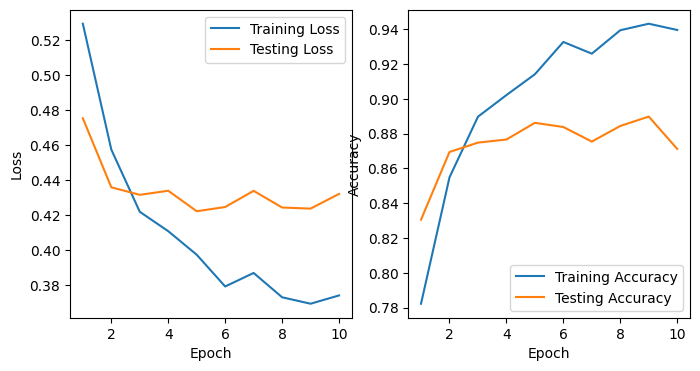

In [9]:
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.2) #changed from 1e-5 and 0.2
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

num_epochs = 10

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        labels = labels.unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        labels = labels.to(outputs.dtype)

        loss = criterion(outputs, labels)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.5).float()

        epoch_train_loss += loss.item()
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Testing
    model.eval()
    epoch_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            labels = labels.unsqueeze(1)

            outputs = model(input_ids, attention_mask)
            labels = labels.to(outputs.dtype)

            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()

            correct_test += (predictions == labels).sum().item()
            total_test += labels.size(0)

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Testing Loss: {avg_test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}')


# Creating subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plotting the loss curves
axs[0].plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
axs[0].plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the accuracy curves
axs[1].plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
axs[1].plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [11]:
# Define the file path where you want to save the model
model_save_path = "protein_classifier_model.pth"

# Save the model parameters
torch.save(model.state_dict(), model_save_path)

print("Model parameters saved successfully at:", model_save_path)


Model parameters saved successfully at: protein_classifier_model.pth


In [13]:
import zipfile
import os

# Define the file paths
model_save_path = "protein_classifier_model.pth"
zip_file_path = "protein_classifier_model.zip"

# Create a zip file and add the .pth file to it
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    zipf.write(model_save_path, os.path.basename(model_save_path))

print("Model parameters zipped successfully at:", zip_file_path)


Model parameters zipped successfully at: protein_classifier_model.zip
